<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/DataFrameMaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init and define function

In [1]:
import sys
import matplotlib.pyplot as plt
%pip -q install uproot3
%pip -q install --upgrade tables
import uproot3
import pandas as pd
h5file='drive/MyDrive/root_files_cry4/cry4df.h5'

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)
sys.path.append(main_path+'root_files_cry4')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def default_flatname(branchname, fieldname, index):
    """This replaces the dot in the column names with underscores"""
    out = branchname.replace(".", "_")
    if not isinstance(branchname, str):
        out = branchname.decode("utf-8")
    if fieldname is not None:
        fieldname.replace(".", "_")
        out += "_" + fieldname
    if index != ():
        out += "[" + "][".join(str(x) for x in index) + "]"
    return out

In [3]:
def make_df(trkana, tag_high, lyield):

  df_eve = trkana.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'demcgen', 'trigbits', 'ue', 'crvsummary*', '_*'], flatname=default_flatname, flatten=True)
  df_crv = trkana.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)
  df_crv = df_crv[df_crv.index.get_level_values('subentry') == df_crv["bestcrv"]]

  pd.merge(df_eve, df_crv, how="left", on='entry')
  df = df_eve.merge(df_crv, how="left", on="entry")
  df['is_high'] = tag_high
  df['lyield'] = int(lyield)
  df["crvinfo__dT"] = df["crvinfo__timeWindowStart"] - df["de_t0"]
  df['deent_d0_om'] = df["deent_d0"]+2.0/df["deent_om"]
  df["is_triggered"] = (df["trigbits"].values & 0x208) > 0
  df = df.fillna(-999999)
  return df

In [4]:
def combine_df(files):
    
  df = pd.DataFrame()
  for f in files:
      print("Reading file", f, files[f][0], files[f][1])
      file = uproot3.open(f)
      trkana = file["TrkAnaNeg"]["trkana"]
      df_ = make_df(trkana, files[f][1], files[f][0])
      df_ = df_[var_list]
      df = df.append(df_)
  df = df.loc[:,~df.columns.duplicated()]  # delete duplicate colummns
  return df    

#Variables list to save in df

In [5]:
var_list=['evtinfo__eventid',
 'evtinfo__subrunid',
 'de_status',
 'de_pdg',
 'de_nhits',
 'de_t0',
 'deent_mom',
 'deent_d0',
 'deent_p0',
 'deent_om',
 'deent_z0',
 'deent_td',
 'dequal_TrkPID',
 'dequal_TrkQual',
 'demc_pdg',
 'demcgen_pdg',
 'demcgen_gen',
 'demcgen_posx',
 'demcgen_posy',
 'demcgen_posz',
 'demcgen_momx',
 'demcgen_momy',
 'demcgen_momz',
 'trigbits',
 'ue_status',
 'ue_nhits',
 '_totalPEs',
 '_nHitCounters',
 '_totalEnergyDeposited',
 '_x',
 '_y',
 '_z',
 '_crvSectorNumber',
 '_crvSectorType',
 'crvinfo__crvSectorType',
 'crvinfo__x',
 'crvinfo__y',
 'crvinfo__z',
 'crvinfo__PEs',
 'crvinfo__timeWindowStart',
 'crvinfo__nCoincidenceHits',
 'crvinfomc__x',
 'crvinfomc__y',
 'crvinfomc__z',
 'bestcrv',
 'is_high',
 'lyield',
 'crvinfo__dT',
 'deent_d0_om',
 'is_triggered']

# Save dataframe

In [6]:
files = {                  
        'drive/MyDrive/root_files_cry4/ana.dzhadan.RecoMC.cry4v940.092020_7000_lo.root': [7000, 0],
        'drive/MyDrive/root_files_cry4/ana.dzhadan.RecoMC.cry4v940.123020_7000_lo.root': [7000, 0],
        'drive/MyDrive/root_files_cry4/ana.dzhadan.RecoMC.cry4v940.092020_9000_lo.root': [9000, 0],
        'drive/MyDrive/root_files_cry4/ana.dzhadan.RecoMC.cry4v940.123020_9000_lo.root': [9000, 0],         
        'drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.092020_11000_lo.root': [11000, 0],
        'drive/MyDrive/root_files_cry4/ana.dzhadan.RecoMC.cry4v940.123020_11000_lo.root': [11000, 0],         
        'drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.092020_13000_lo.root': [13000, 0],
        'drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.123020_13000_lo.root': [13000, 0],
        'drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.092020_15000_lo.root': [15000, 0],
        'drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.123020_15000_lo.root': [15000, 0],        
        'drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.092020_17000_lo.root': [17000, 0],
        'drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.123020_17000_lo.root': [17000, 0],
        
        'drive/MyDrive/root_files_cry4/ana.dzhadan.RecoMC.cry4v940.092020_7000_hi.root': [7000, 1],
        'drive/MyDrive/root_files_cry4/ana.dzhadan.RecoMC.cry4v940.092020_9000_hi.root': [9000, 1],
        'drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.092020_11000_hi.root': [11000, 1],
        'drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.092020_13000_hi.root': [13000, 1],
        'drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.092020_15000_hi.root': [15000, 1],
        'drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.092020_17000_hi.root': [17000, 1],
        }

In [7]:
df = combine_df(files)

Reading file drive/MyDrive/root_files_cry4/ana.dzhadan.RecoMC.cry4v940.092020_7000_lo.root 7000 0
Reading file drive/MyDrive/root_files_cry4/ana.dzhadan.RecoMC.cry4v940.123020_7000_lo.root 7000 0
Reading file drive/MyDrive/root_files_cry4/ana.dzhadan.RecoMC.cry4v940.092020_9000_lo.root 9000 0
Reading file drive/MyDrive/root_files_cry4/ana.dzhadan.RecoMC.cry4v940.123020_9000_lo.root 9000 0
Reading file drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.092020_11000_lo.root 11000 0
Reading file drive/MyDrive/root_files_cry4/ana.dzhadan.RecoMC.cry4v940.123020_11000_lo.root 11000 0
Reading file drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.092020_13000_lo.root 13000 0
Reading file drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.123020_13000_lo.root 13000 0
Reading file drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.092020_15000_lo.root 15000 0
Reading file drive/MyDrive/root_files_cry4/ana.amirkhan.RecoMC.cry4v940.123020_15000_lo.root 15000 0
Rea

In [17]:
df.to_hdf(h5file, key='cry4')

#Load dataframe

In [5]:
df = pd.read_hdf(h5file, mode='r')

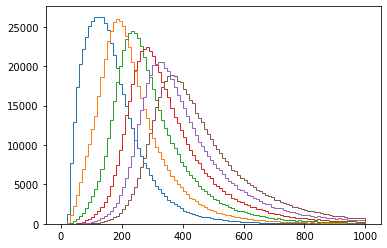

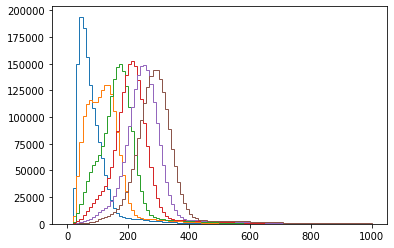

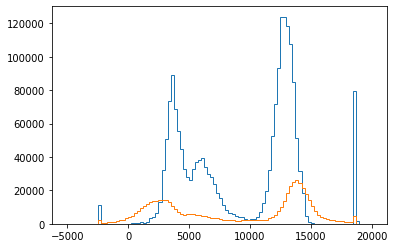

In [6]:
for l in range(7000,17001,2000):
  plt.hist(df.query('is_high==1 & lyield==%i' % l)['crvinfo__PEs'], bins=100, range=(0, 1000), histtype='step');
plt.figure()
for l in range(7000,17001,2000):
  plt.hist(df.query('is_high==0 & lyield==%i' % l)['crvinfo__PEs'], bins=100, range=(0, 1000), histtype='step');
plt.figure()
plt.hist(df.query('is_high==0 & lyield==%i' % 17000)['_z'], bins=100, range=(-5000, 20000), histtype='step');
plt.hist(df.query('is_high==1 & lyield==%i' % 17000)['_z'], bins=100, range=(-5000, 20000), histtype='step');